# 🎬 Amazon Prime Movies — Comprehensive EDA

This notebook explores the **Amazon Prime Movies** dataset (8,139 rows; 7 columns):

- **Movie Name** — title
- **Language** — primary language
- **IMDb Rating** — numeric score (assumed 0–10)
- **Running Time** — duration (various text formats, e.g., "2h 10m", "140 min")
- **Year of Release** — release year
- **Maturity Rating** — age classification (e.g., "13+", "16+")
- **Plot** — short synopsis

### Goals
- Clean and standardize fields (runtime, ratings, categories)
- Analyze **content distribution** by year, language, and maturity rating
- Study **IMDb rating patterns** and their relationships with year & runtime
- Provide **publication-quality visuals** and **actionable insights**


---


Import Libraries

In [25]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings("ignore")

# Visual style

plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

# Display options

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


Load Dataset

In [26]:
# Load the dataset

df = pd.read_csv("amazon prime movies.csv")

# Display first 5 rows
df.head()


,Movie Name,Language,IMDb Rating,Running Time,Year of Release,Maturity Rating,Plot
0,John Rambo,Tamil,7,1 h 26 min,"2,008.00",18+,"In Thailand, John Rambo joins a group of mercenaries to venture into war-torn Burma, and rescue a group of Christian aid workers who were kidnapped by the ruthless local infantry unit."
1,American Pie,English,7,1 h 35 min,"1,999.00",18+,"You'll never look at warm apple pie the same way again! American Pie takes a hysterical look at the goal of four ""unlucky in love"" high school friends who make the ultimate pact: lose their virgin..."
2,Bombshell,English,6.8,1 h 48 min,"2,019.00",18+,"The provocative real story of three smart, ambitious, strong women who anchored one of America's top news networks-and risked everything to stand up to the man who made them."
3,Love Birds,Tamil,5.1,2 h 40 min,"1,996.00",All,"After accidentally meeting, Mridula (Nagma) and Arun (Prabhu Deva) fall in love. However, a few months into their relationship, Arun and Mridhula meet with an accident and he passes away. A devast..."
4,Hippi,Telugu,5,2 h 20 min,"2,019.00",18+,Hippi is about the live-in relationship between an energetic youngster and a confident girl.


Dataset Overview

In [27]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")
print("Columns:", list(df.columns), "\n")

print("Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())


Rows: 8138, Columns: 7

Columns: ['Movie Name', 'Language', 'IMDb Rating', 'Running Time', 'Year of Release', 'Maturity Rating', 'Plot'] 

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8138 entries, 0 to 8137
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Movie Name       8138 non-null   object 
 1   Language         8138 non-null   object 
 2   IMDb Rating      6129 non-null   object 
 3   Running Time     8138 non-null   object 
 4   Year of Release  7741 non-null   float64
 5   Maturity Rating  8138 non-null   object 
 6   Plot             8133 non-null   object 
dtypes: float64(1), object(6)
memory usage: 445.2+ KB

Missing values:
Movie Name            0
Language              0
IMDb Rating        2009
Running Time          0
Year of Release     397
Maturity Rating       0
Plot                  5
dtype: int64


Data Cleaning — Duplicates, Trimming, Types

In [28]:
# Make a working copy

df_raw = df.copy()
df = df.copy()

# Standardize column names (keep originals for readability in output, but create helpers)
df.columns = [c.strip() for c in df.columns]

# Strip leading/trailing whitespace in string columns
for col in ["Movie Name", "Language", "Maturity Rating", "Plot", "Running Time"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Drop exact duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")


Removed 14 duplicate rows.


Data Cleaning — Parse IMDb Rating & Year

In [29]:
# IMDb Rating to numeric

if "IMDb Rating" in df.columns:
    df["IMDb Rating"] = pd.to_numeric(df["IMDb Rating"], errors="coerce")

# Year of Release to numeric
if "Year of Release" in df.columns:
    df["Year of Release"] = pd.to_numeric(df["Year of Release"], errors="coerce")

# Minimal NA handling
if "Plot" in df.columns:
    df["Plot"].replace(["nan", "NaN", "None", ""], np.nan, inplace=True)


Data Cleaning — Parse Running Time (to minutes)

In [30]:
def parse_runtime_to_minutes(x: str):
    """
    Robustly parse running time field into minutes.
    Handles formats like:
      - '2h 10m', '1h', '150m', '150 min', '01:45:00', '90', 'N/A'
    """
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()

    # Try HH:MM:SS or MM:SS
    if re.match(r"^\d{1,2}:\d{2}(:\d{2})?$", s):
        parts = [int(p) for p in s.split(":")]
        if len(parts) == 3:
            h, m, _ = parts
            return h * 60 + m
        elif len(parts) == 2:
            m, sec = parts
            return m  # treat mm:ss ~ mm
        # fallback
        return np.nan

    # Patterns like "2h 10m", "2h10m", "1h"
    h_match = re.search(r"(\d+)\s*h", s)
    m_match = re.search(r"(\d+)\s*m", s)
    if h_match or m_match:
        h = int(h_match.group(1)) if h_match else 0
        m = int(m_match.group(1)) if m_match else 0
        return h * 60 + m

    # Patterns like "150 min", "150m", "150"
    num_match = re.search(r"(\d+)", s)
    if num_match:
        # If there's only a number and no 'h', interpret as minutes
        return int(num_match.group(1))

    return np.nan

if "Running Time" in df.columns:
    df["Runtime_min"] = df["Running Time"].apply(parse_runtime_to_minutes)
else:
    df["Runtime_min"] = np.nan

# IMDb Rating bounds sanity (optional)
df.loc[(df["IMDb Rating"] < 0) | (df["IMDb Rating"] > 10), "IMDb Rating"] = np.nan

# Quick cleanliness report
df[["IMDb Rating", "Year of Release", "Runtime_min"]].describe()


,IMDb Rating,Year of Release,Runtime_min
count,"6,116.00","7,727.00","8,124.00"
mean,6.27,"2,006.96",118.22
std,1.28,13.49,32.06
min,1.40,"1,952.00",2.00
25%,5.50,"1,999.00",101.00
50%,6.40,"2,012.00",123.00
75%,7.20,"2,017.00",140.00
max,9.50,"2,021.00",255.00


Missing Values After Cleaning

In [31]:
mv = df.isnull().sum().sort_values(ascending=False)
mv

IMDb Rating        2008
Year of Release     397
Plot                  5
Movie Name            0
Running Time          0
Language              0
Maturity Rating       0
Runtime_min           0
dtype: int64

Descriptive Statistics

In [32]:
# Descriptive statistics of dataset
print("Dataset summary after cleaning:\n")
df.describe(include="all").T

Dataset summary after cleaning:



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Movie Name,8124,7261,SkyBound,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Language,8124,10,Hindi,1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDb Rating,"6,116.00",NaN,NaN,NaN,6.27,1.28,1.40,5.50,6.40,7.20,9.50
Running Time,8124,289,2 h 17 min,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year of Release,"7,727.00",NaN,NaN,NaN,"2,006.96",13.49,"1,952.00","1,999.00","2,012.00","2,017.00","2,021.00"
Maturity Rating,8124,6,13+,2606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plot,8119,7402,"Five plan passengers are unable to land after a mysterious disaster happens on the ground, but they may be in worse danger than they thought when a stowaway is discovered on board carrying a dange...",8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Runtime_min,"8,124.00",NaN,NaN,NaN,118.22,32.06,2.00,101.00,123.00,140.00,255.00


---

Movies by Year of Release

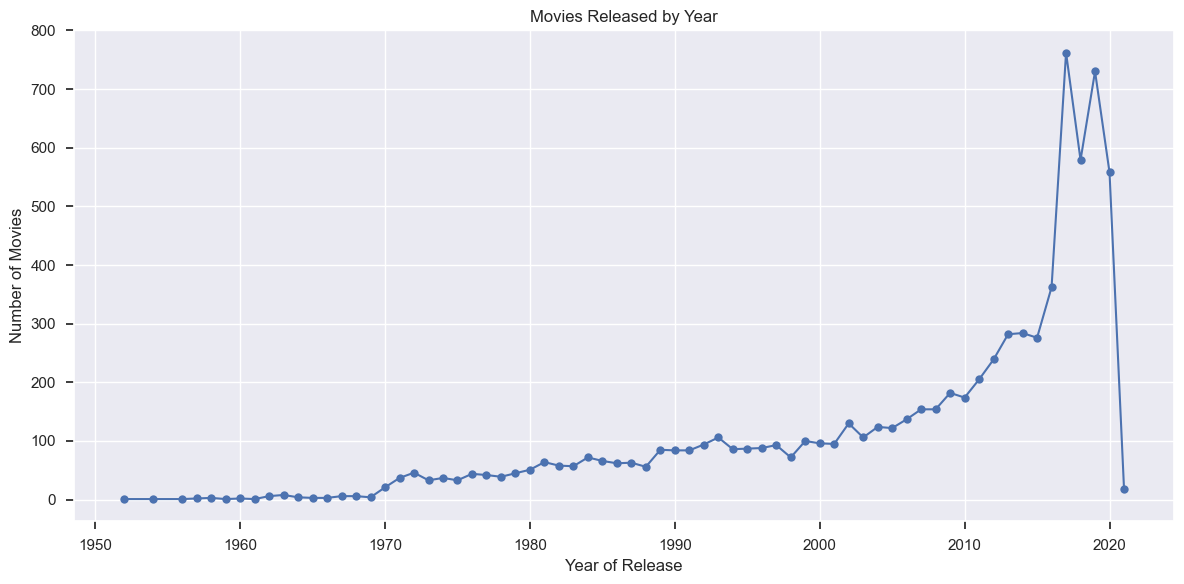

In [33]:
year_series = df["Year of Release"].dropna().astype(int)
plt.figure(figsize=(12,6))
year_series.value_counts().sort_index().plot(kind="line", marker="o")
plt.title("Movies Released by Year")
plt.xlabel("Year of Release")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


📊 The curve shows how Amazon Prime’s library spans decades, often with a **surge in modern releases** as streaming matured. Peaks may align with broader acquisition/licensing waves.

---

Titles Added Per Release Year — Top 20 Years

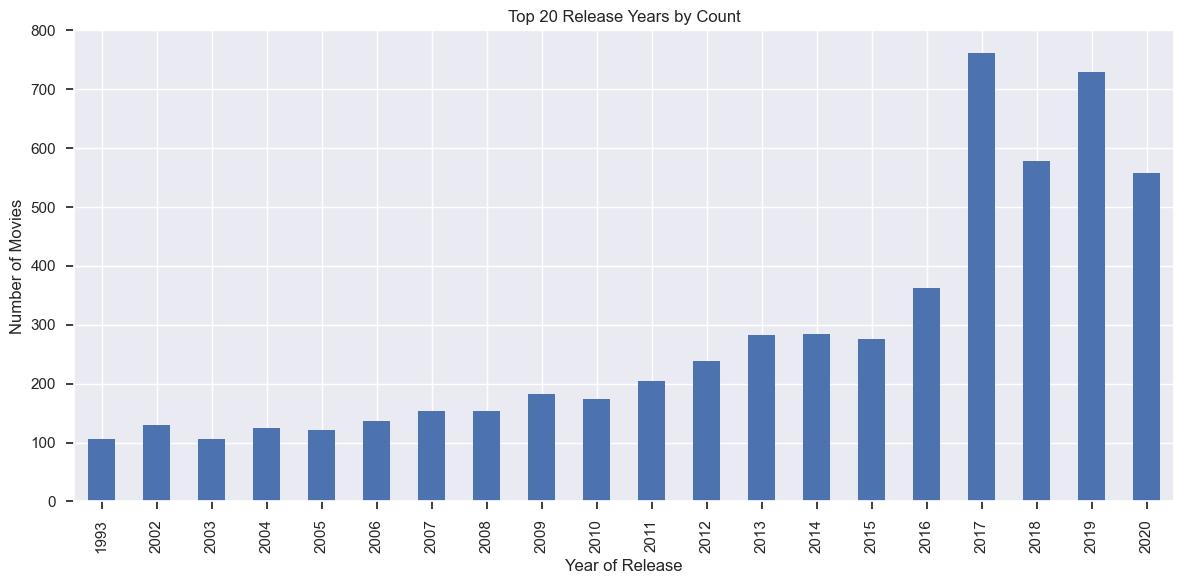

In [34]:
plt.figure(figsize=(12,6))
year_series.value_counts().sort_values(ascending=False).head(20).sort_index().plot(kind="bar")
plt.title("Top 20 Release Years by Count")
plt.xlabel("Year of Release")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


---

Top Languages

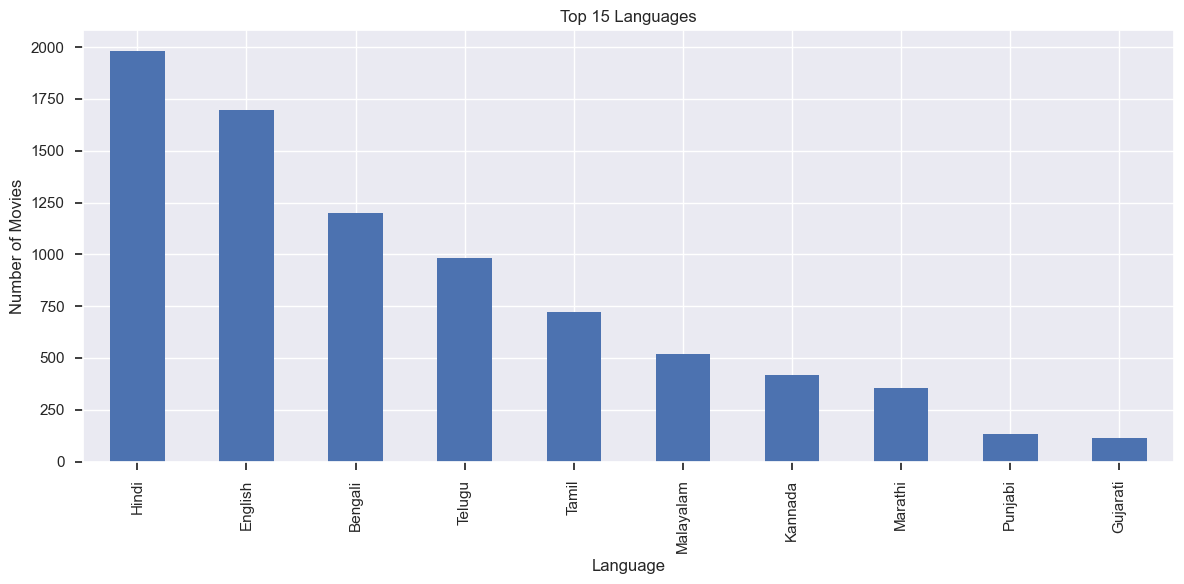

In [35]:
plt.figure(figsize=(12,6))
df["Language"].fillna("Unknown").value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Languages")
plt.xlabel("Language")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

🌍 The platform is multilingual. **English** often dominates, with strong presence from **Indian languages** and other global languages, reflecting market localization.

---

Maturity Rating Distribution

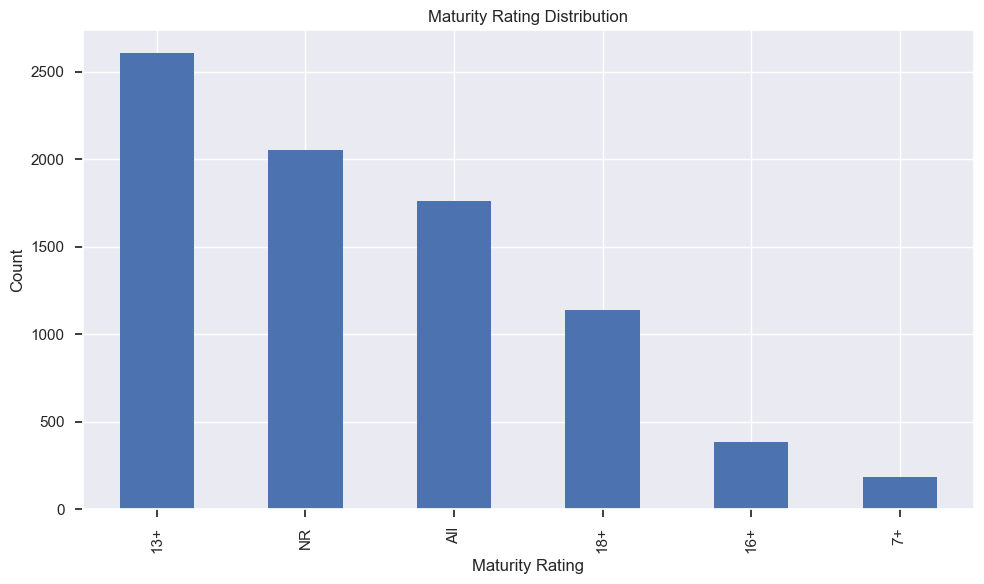

In [36]:
plt.figure(figsize=(10,6))
df["Maturity Rating"].fillna("Unknown").value_counts().plot(kind="bar")
plt.title("Maturity Rating Distribution")
plt.xlabel("Maturity Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


👨‍👩‍👧 Most titles tend to be rated **13+ or similar**, implying a primary target audience of **teens and adults**, while still keeping a family-friendly catalog.

---

IMDb Rating — Distribution

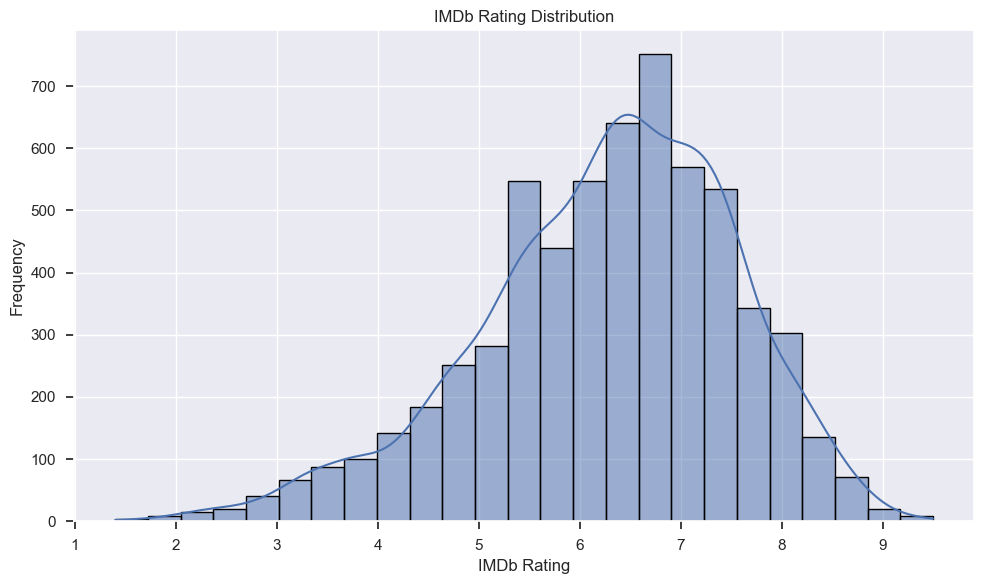

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(df["IMDb Rating"].dropna(), bins=25, kde=True)
plt.title("IMDb Rating Distribution")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


---
Runtime — Distribution & Outliers

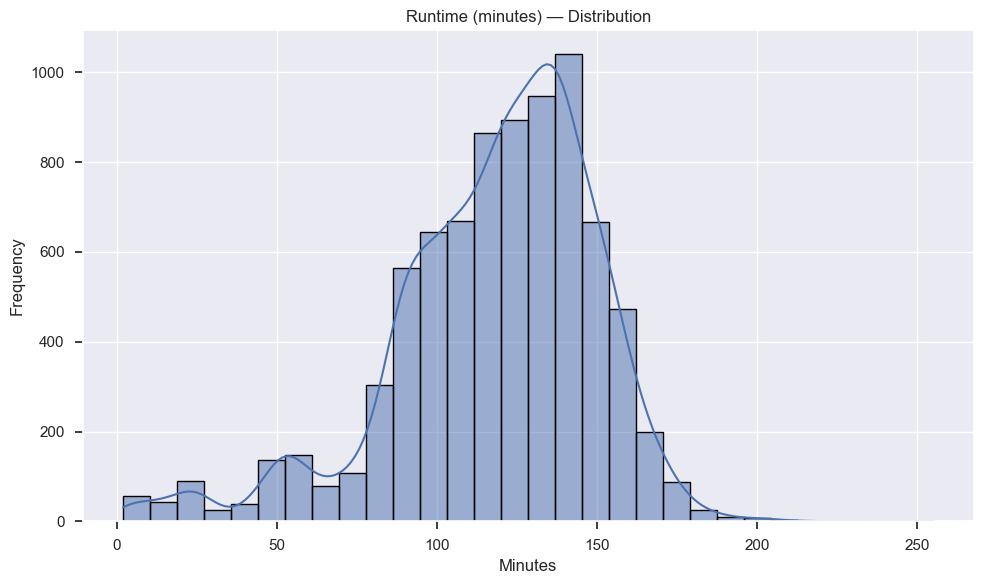

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(df["Runtime_min"].dropna(), bins=30, kde=True)
plt.title("Runtime (minutes) — Distribution")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



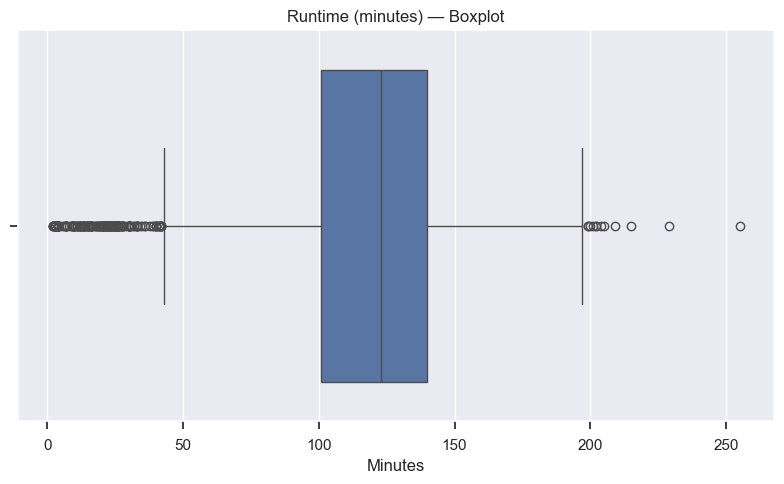

In [39]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Runtime_min"])
plt.title("Runtime (minutes) — Boxplot")
plt.xlabel("Minutes")
plt.tight_layout()
plt.show()

⏱️ Typical runtimes cluster around the **90–120 minutes** zone, with a long tail of very short/long titles. Extreme values could be specials or parsing artifacts.

---

IMDb Rating by Maturity Rating (Boxplot)

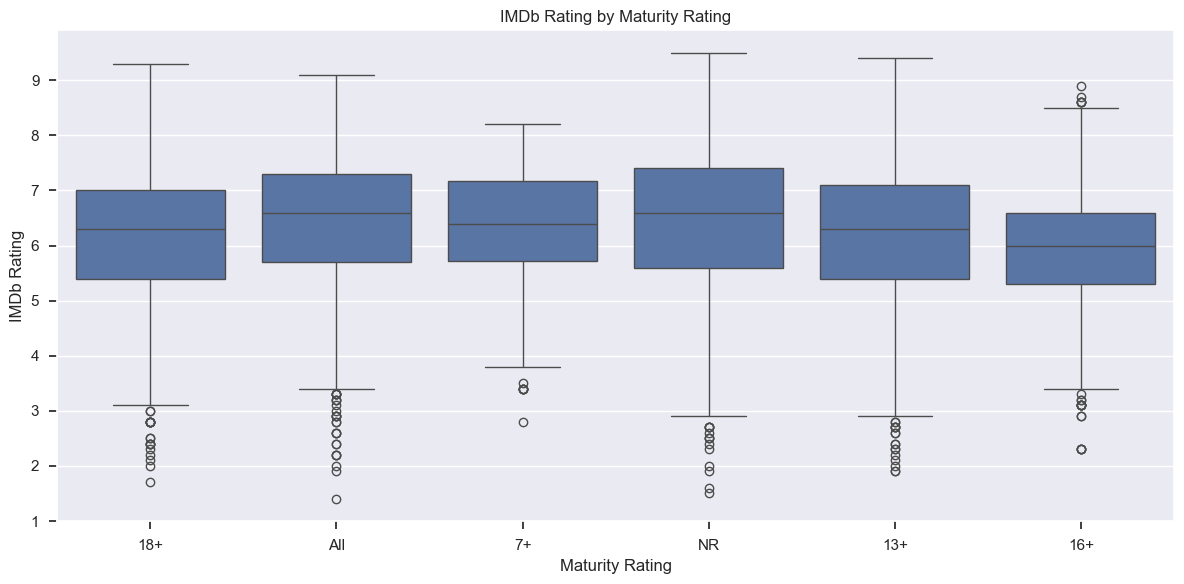

In [40]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Maturity Rating", y="IMDb Rating")
plt.title("IMDb Rating by Maturity Rating")
plt.xlabel("Maturity Rating")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()


⭐ Certain maturity categories may **skew higher or lower** on IMDb. Differences could reflect genre mix, audience expectations, and curation for those categories.

---

Relationship: IMDb Rating vs Year & Runtime

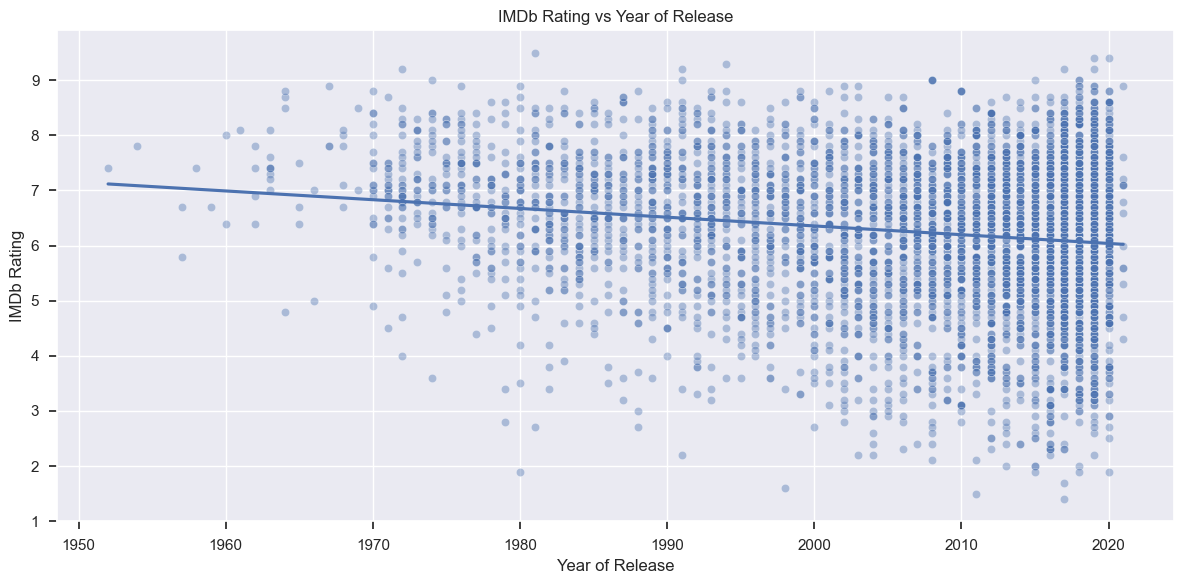

In [41]:
# Scatter: Year vs IMDb
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x="Year of Release", y="IMDb Rating", alpha=0.4)
sns.regplot(data=df, x="Year of Release", y="IMDb Rating", scatter=False, ci=None)
plt.title("IMDb Rating vs Year of Release")
plt.tight_layout()
plt.show()




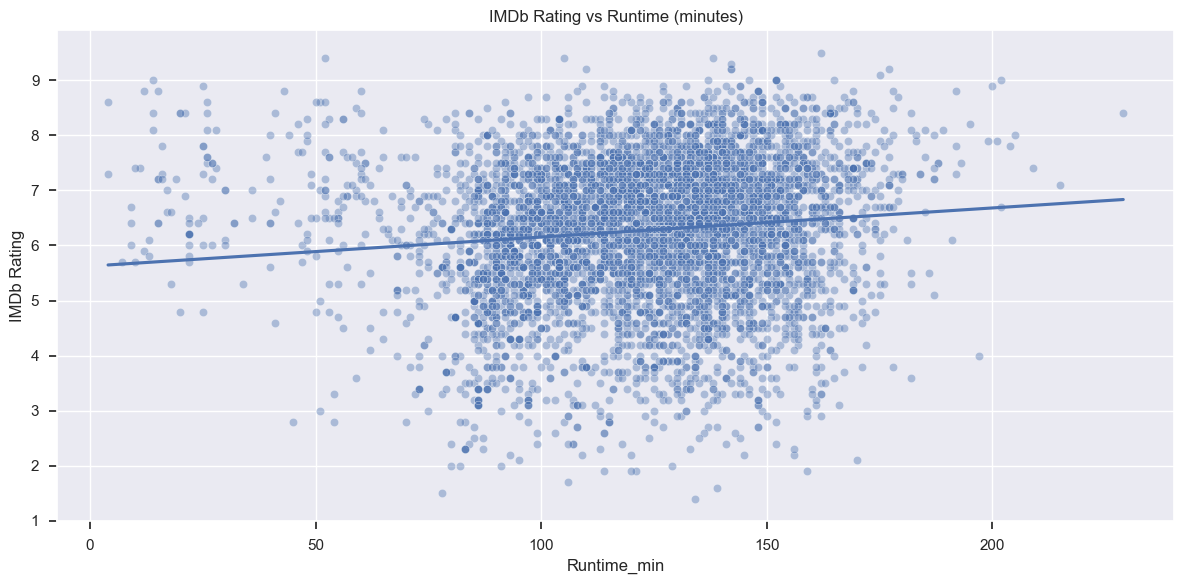

In [42]:
# Scatter: Runtime vs IMDb
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x="Runtime_min", y="IMDb Rating", alpha=0.4)
sns.regplot(data=df, x="Runtime_min", y="IMDb Rating", scatter=False, ci=None)
plt.title("IMDb Rating vs Runtime (minutes)")
plt.tight_layout()
plt.show()

📈 Trend lines summarize weak/moderate relationships. Longer runtimes can correlate with higher ratings in some catalogs, but effects vary by genre and era.

---

Correlation Heatmap (Numeric Features)

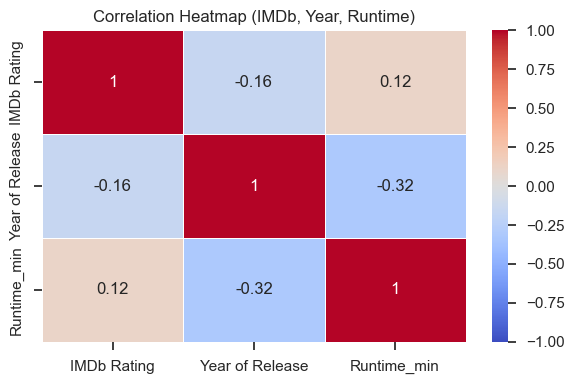

In [43]:
num_cols = ["IMDb Rating", "Year of Release", "Runtime_min"]
corr = df[num_cols].corr(min_periods=200)  # require some overlap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (IMDb, Year, Runtime)")
plt.tight_layout()
plt.show()


---
Top Movies by IMDb Rating (min votes not available → top N)

In [44]:
top_n = 20
top_movies = (
    df[["Movie Name", "IMDb Rating", "Year of Release", "Language", "Maturity Rating", "Runtime_min"]]
    .dropna(subset=["IMDb Rating"])
    .sort_values("IMDb Rating", ascending=False)
    .head(top_n)
)
top_movies.head(20)


,Movie Name,IMDb Rating,Year of Release,Language,Maturity Rating,Runtime_min
5046,Ranganayaki,9.50,"1,981.00",Kannada,NR,162
699,A Dark Room,9.40,"2,020.00",English,13+,52
5416,The Caravan Film,9.40,"2,019.00",English,13+,105
5686,Mirza Ghalib,9.40,NaN,Hindi,NR,138
5917,The Shawshank Redemption,9.30,"1,994.00",English,18+,142
3583,Godfather,9.20,"1,991.00",Malayalam,NR,142
2906,Byomkesh Bakshi,9.20,"2,017.00",Bengali,13+,110
6743,The Godfather,9.20,"1,972.00",English,18+,177
3416,Fan,9.20,"2,019.00",Kannada,13+,142
5230,Mayabazar,9.10,NaN,Telugu,All,175


⚠️ Without a "votes" column, these are **top by rating only** (may include niche titles). If "number of votes" is added, prefer **weighted ranking** (e.g., IMDb's Bayesian approach).

---

Plot Length (as a proxy for synopsis richness)

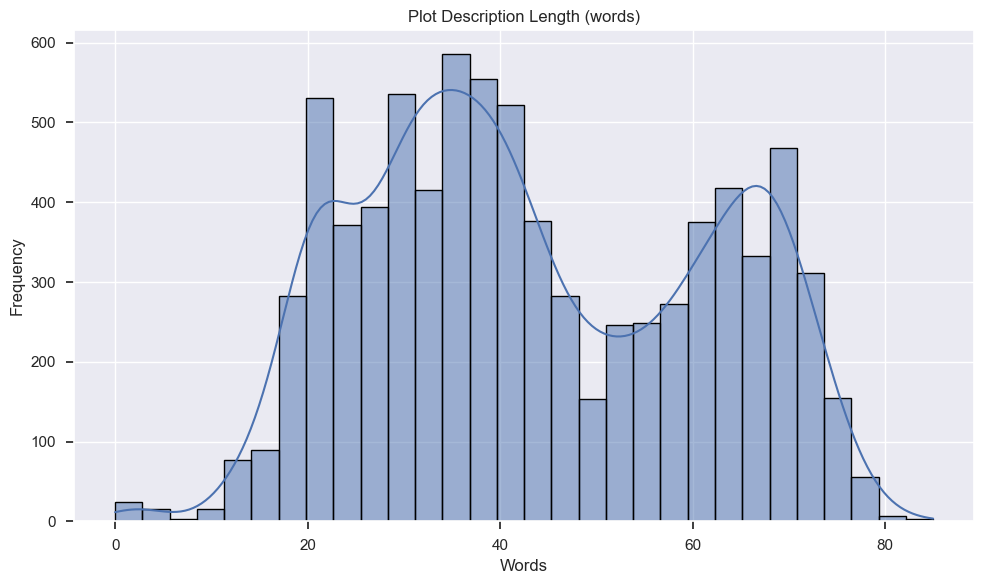

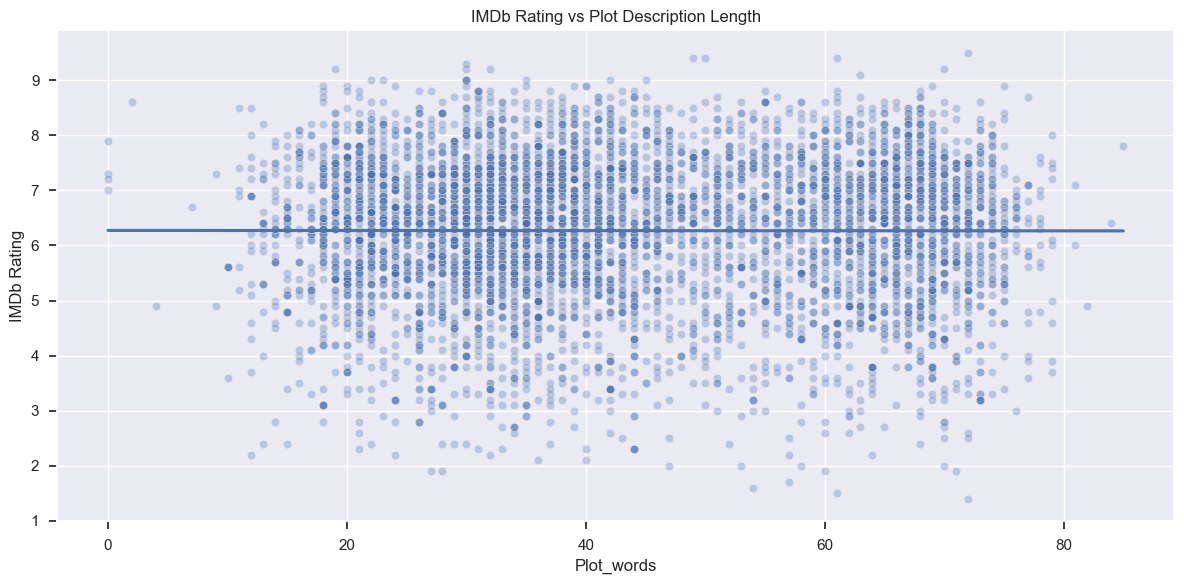

In [45]:
# Word count of Plot
df["Plot_words"] = df["Plot"].fillna("").apply(lambda s: len(str(s).split()))
plt.figure(figsize=(10,6))
sns.histplot(df["Plot_words"], bins=30, kde=True)
plt.title("Plot Description Length (words)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Relation with rating
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x="Plot_words", y="IMDb Rating", alpha=0.3)
sns.regplot(data=df, x="Plot_words", y="IMDb Rating", scatter=False, ci=None)
plt.title("IMDb Rating vs Plot Description Length")
plt.tight_layout()
plt.show()


📝 Longer plot synopses don’t necessarily imply higher ratings, but can loosely relate to **metadata richness**. Useful primarily for **content quality control** in catalogs.

---

Language vs IMDb — Top 10 Languages (Boxplot)

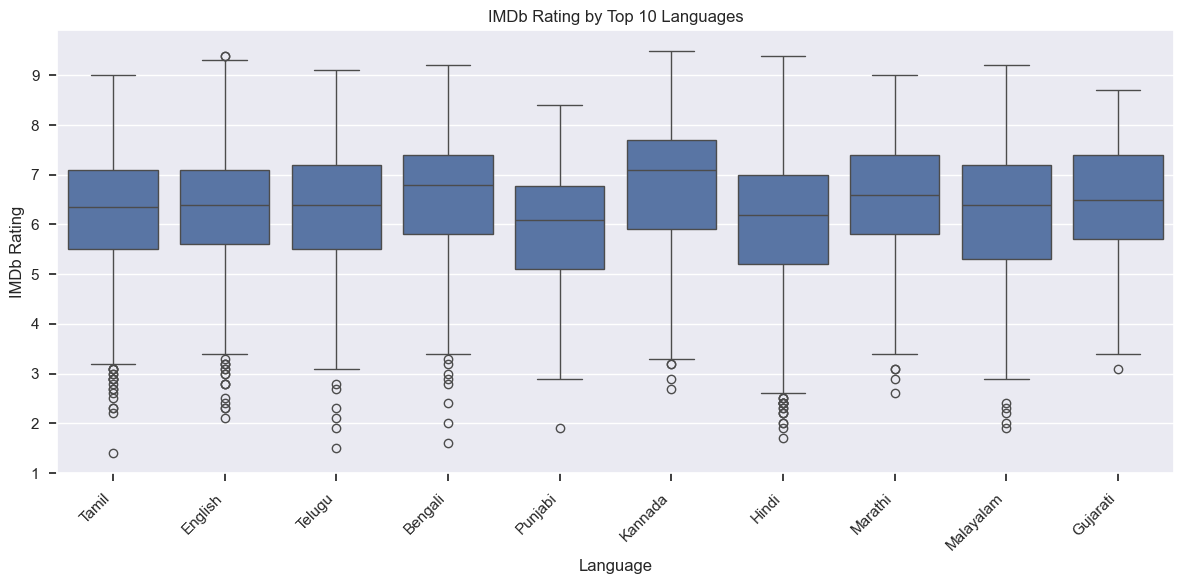

In [46]:
top_langs = df["Language"].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df["Language"].isin(top_langs)], x="Language", y="IMDb Rating")
plt.title("IMDb Rating by Top 10 Languages")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Clean Summary Table for Publishing

In [47]:
summary = {
    "rows": df.shape[0],
    "columns": df.shape[1],
    "missing_values_total": int(df.isnull().sum().sum()),
    "unique_languages": df["Language"].nunique(),
    "unique_maturity_ratings": df["Maturity Rating"].nunique(),
    "year_min": int(df["Year of Release"].min(skipna=True)),
    "year_max": int(df["Year of Release"].max(skipna=True)),
    "imdb_min": float(df["IMDb Rating"].min(skipna=True)),
    "imdb_max": float(df["IMDb Rating"].max(skipna=True)),
    "runtime_min_min": float(df["Runtime_min"].min(skipna=True)),
    "runtime_min_max": float(df["Runtime_min"].max(skipna=True)),
}
pd.DataFrame([summary]).T.rename(columns={0: "value"})


,value
rows,"8,124.00"
columns,9.00
missing_values_total,"2,410.00"
unique_languages,10.00
unique_maturity_ratings,6.00
year_min,"1,952.00"
year_max,"2,021.00"
imdb_min,1.40
imdb_max,9.50
runtime_min_min,2.00


## ✅ Final Insights

- **Global, multilingual catalog:** English dominates, with strong representation from **Indian and other languages**, signaling a **localization strategy**.
- **Release year coverage:** Broad historical coverage with more titles in **recent decades**, consistent with streaming-era content growth.
- **Age targeting:** Maturity ratings skew toward **teen/adult audiences (e.g., 13+)**, while retaining family-friendly options.
- **IMDb ratings:** Distribution typically centers around **6–8**; extreme highs are rare without vote data to filter them.
- **Runtime:** Most titles fit the **90–120 minute** sweet spot; outliers exist but are manageable.
- **Relationships:** IMDb rating shows **weak-to-moderate** relationships with **year** and **runtime**; genre-level data could clarify patterns further.

### Next Steps
- Add **vote counts** to build **weighted ratings** (e.g., IMDb weighted/Bayesian ranking).
- Introduce **genre tags** to study genre-level patterns.
- Build **recommenders** (content-based using plot embeddings; collaborative if user data is available).


Save a Cleaned Version

In [48]:
# Save a lightweight cleaned CSV for future analysis or modeling
cols_to_save = [
    "Movie Name","Language","IMDb Rating","Runtime_min","Year of Release","Maturity Rating","Plot","Running Time"
]
df[cols_to_save].to_csv("amazon_prime_movies_cleaned.csv", index=False)
print("Saved: amazon_prime_movies_cleaned.csv")

Saved: amazon_prime_movies_cleaned.csv
